In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
import qubit_templates
from qubit_templates import *
from functions import *

# Read configuration file

In [3]:
wafertype = "silicon" # silicon or sapphire
JJtype = "manhattan" # manhattan or dolan
Squid = True

outname = "waferdesign_3D_" + wafertype + "_" + JJtype + "_photolitho"

config = load_config( f"config/common.yaml" )
globals().update(config)
qubit_templates.__dict__.update(config)

config = load_config( f"config/{JJtype}_3D_{wafertype}_photolitho.yaml" )
globals().update(config)
qubit_templates.__dict__.update(config)

# Wafer design

In [4]:
wafer = device_Wafer(inch = 4)

# Chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


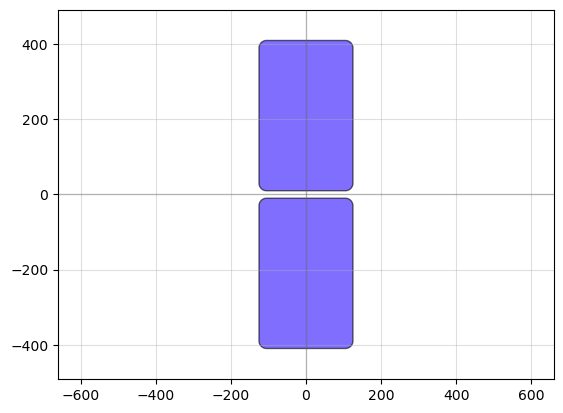

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


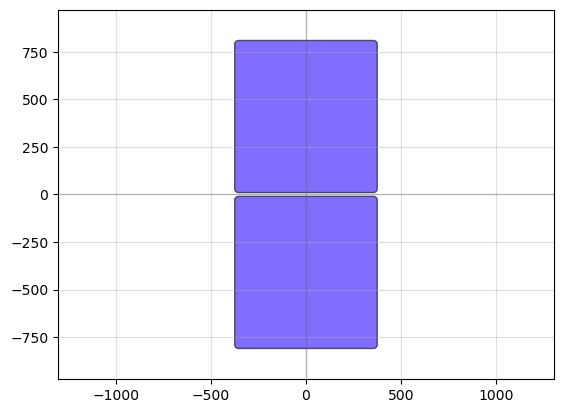

In [5]:
chipdesign = {}
for size in ['S','L']:
    chipdesign[size] = Device(f'chipdesign_{size}')

    PAD=Device('PAD')
    if size == 'L':
        rectangle = pg.rectangle(( 3*Pad_width, 2.*Pad_height), Pad_layer)
    else:
        rectangle = pg.rectangle(( Pad_width, Pad_height), Pad_layer)

    rectangle.polygons[0].fillet( Pad_rounding )
    PAD.add_ref( rectangle ).movex(0).movey(0.5*Pad_gap)
    PAD.add_ref( rectangle ).mirror(p1 = (0, 0), p2 = (200, 0)).movex(0).movey(-0.5*Pad_gap)
    PAD.center = (0, 0)

    chipdesign[size].add_ref(PAD)


    # Quickplot the imported design
    qp(chipdesign[size])


# Josephson Junction

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


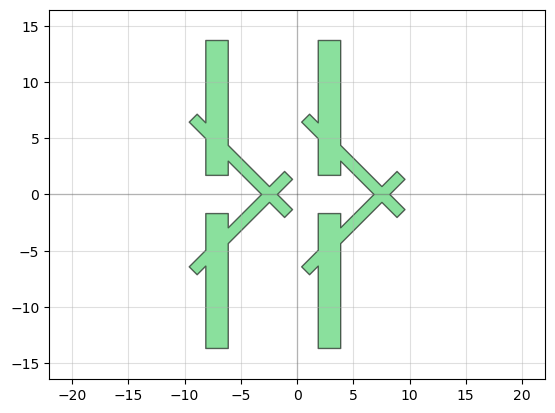

In [6]:
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = True, bandage = False, photolitho = True)
JJ = device_JJ(width = 1.0, JJtype = JJtype, squid = Squid, bandage = False, photolitho = True)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = True, bandage = True)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = False, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = True)
qp(JJ)


# Add JJ to chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


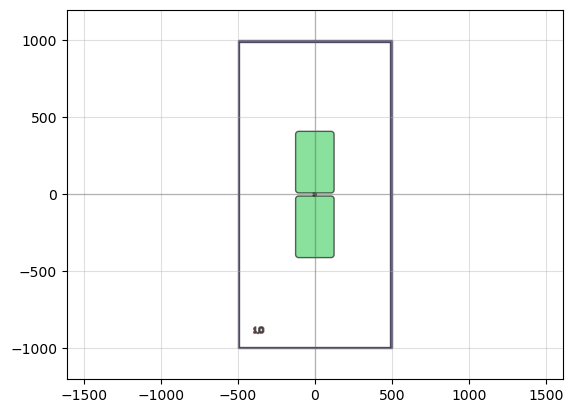

'output/chipdesign_3D.gds'

In [ ]:
def custom_chip(width, height, padsize = 'S'):
    chip = Device('chip')
    chip.add_ref(chipdesign[padsize])

    if JJtype == "dolan":
        JJ = device_JJ(bridge_width = height, finger_width = width, JJtype = JJtype, squid = Squid , bandage = False, photolitho = True )
    else:
        JJ = device_JJ(width = width, JJtype = JJtype, squid = Squid , bandage = False, photolitho = True)
    chip.add_ref(JJ)

    chip = pg.union( chip )
    for pol in chip.polygons: # unions are separated in dolan structure, so loop through all polygons
        pol.fillet( Pad_JJ_rounding )
    chip = pg.union( chip )

    text = eval(Text_string, {"width": width, "height": height})
    move_x = Text_pos_x*0.5*Chip_size_x
    move_y = Text_pos_y*0.5*Chip_size_y    

    T = pg.text(text, size=40, layer = Text_layer)
    T.move([move_x,move_y])
    chip.add_ref(T)

    FM=Device('frame')
    new_Frame_width = 0.1*Frame_width
    rectangle = pg.rectangle((Chip_size_x - 2*new_Frame_width, Chip_size_y - 2*new_Frame_width), Frame_layer)
    FM.add_ref( pg.invert(rectangle, border = new_Frame_width, precision = 1e-6, layer = Frame_layer) )
    FM.center = (0, 0)
    chip.add_ref(FM)

    return chip

chip = custom_chip(width = 1.0, height = 0.2)
qp(chip)
chip.write_gds('output/chipdesign_3D')

# Place chip designs

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Device (name "grid" (uid 9705), ports [], aliases [], 0 polygons, 32 references)


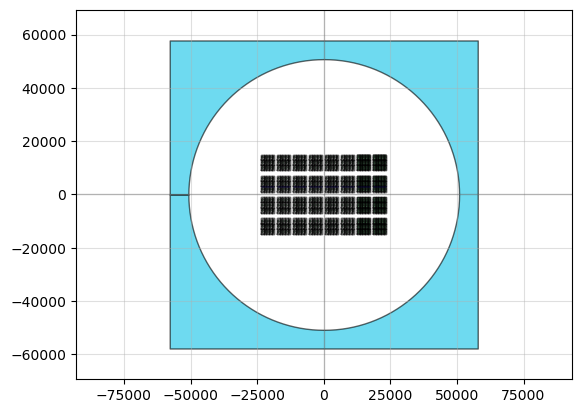

In [8]:
def custom_design(size_x, size_y,  width, height, padsize):

    design = pg.gridsweep(
        function = custom_chip,
        param_x = {'width'  : width },
        param_y = {'height' : height },
        spacing = (0, 0),
        param_defaults = {'padsize' : padsize},
        label_layer = None
        )
    design.center = (0,0)
    return design

if wafertype == "sapphire":
    D = pg.gridsweep(
            function = custom_design,
            param_x = {'width' : Grid_finger_width },
            param_y = {'height' : Grid_finger_height },
            param_defaults = {'size_x' : Chip_size_x, 'size_y' : Chip_size_y},
            spacing = (Chip_size_x * (len(Grid_finger_width[0]) + Grid_gap_x), Chip_size_y * (len(Grid_finger_height[0]) + Grid_gap_y)),
            separation = False,
            label_layer = None
            )
    # D.center = ( - 0.5 * len(Grid_bridge_width) * Chip_size_x * (len(Grid_bridge_width[0]) + Grid_gap_x) ,0)
    D.center = ( 0 ,0)
    wafer.add_ref(D)

    # D = pg.gridsweep(
    #         function = custom_design,
    #         param_x = {'bridge_width' : Grid_small_bridge_width },
    #         param_y = {'finger_width' : Grid_small_finger_width },
    #         param_defaults = {'size_x' : Chip_small_size_x, 'size_y' : Chip_small_size_y},
    #         spacing = (Chip_small_size_x * (len(Grid_small_bridge_width[0]) + Grid_small_gap_x), Chip_small_size_y * (len(Grid_small_finger_width[0]) + Grid_small_gap_y)),
    #         separation = False,
    #         label_layer = None
    #         )
    # D.center = ( 0.5 * len(Grid_small_bridge_width) * Chip_small_size_x * (len(Grid_small_bridge_width[0]) + Grid_small_gap_x) ,0)


    # wafer.add_ref(D)
    qp(D)

else:
    D = pg.gridsweep(
            function = custom_design,
            param_x = {'padsize' : Grid_pad_size, 'width' : Grid_finger_width}, # Later dictionary iterates first
            param_y = {'height' : Grid_finger_height }, 
            param_defaults = {'size_x' : Chip_size_x, 'size_y' : Chip_size_y},            
            #spacing = (Chip_size_x * (len(Grid_finger_width[0]) + Grid_gap_x), Chip_size_y * (len(Grid_finger_height[0]) + Grid_gap_y)),
            spacing = (Chip_size_x*Grid_gap_x, Chip_size_y*Grid_gap_y),
            #separation = False,
            label_layer = None
            )
    print(D)

    # island_width = len(Grid_finger_width[0]) * Chip_size_x 
    # island_height = len(Grid_finger_height[0]) * Chip_size_y     
    # island_gap_width = Chip_size_x * Grid_gap_x
    # island_gap_height = Chip_size_y * Grid_gap_y    
    # D.movex( - 3.5 * (island_width + island_gap_width) )
    # D.movey( - 1.5 * (island_height + island_gap_height) )  
    D.center = (0, 0)  
    wafer.add_ref(D)

    qp(wafer)

# Place dicing marker

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


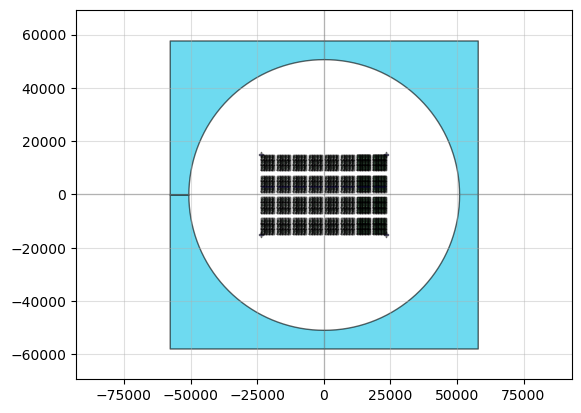

In [9]:

if wafertype == "sapphire":
    DicingMarker = device_DicingMarkers(
        width  = DicingMarker_width, 
        length = DicingMarker_length, 
        layer  = DicingMarker_layer
    )

    spacing_x = Chip_size_x * Grid_gap_x * (len(Grid_finger_width) - 1) + Chip_size_x * len(Grid_finger_width) * len(Grid_finger_width[0])
    spacing_y = Chip_size_y * Grid_gap_y * (len(Grid_finger_height) - 1) + Chip_size_y * len(Grid_finger_height) * len(Grid_finger_height[0])

    # wafer.add_ref(DicingMarker).center = (0, 0)

    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x,  0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x,  0.5*spacing_y)

    # wafer.add_ref(DicingMarker).center = (-spacing_x, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = (-spacing_x,  0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = (         0, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = (         0,  0.5*spacing_y)

    # spacing_x = Chip_small_size_x * Grid_small_gap_x * (len(Grid_small_bridge_width) - 1) + Chip_small_size_x * len(Grid_small_bridge_width) * len(Grid_small_bridge_width[0])
    # spacing_y = Chip_small_size_y * Grid_small_gap_y * (len(Grid_small_finger_width) - 1) + Chip_small_size_y * len(Grid_small_finger_width) * len(Grid_small_finger_width[0])

    # # wafer.add_ref(DicingMarker).center = (0, 0)

    # wafer.add_ref(DicingMarker).center = ( spacing_x, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = ( spacing_x,  0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = ( 0, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = ( 0,  0.5*spacing_y)

else:
    DicingMarker = device_DicingMarkers(
        width  = DicingMarker_width, 
        length = DicingMarker_length, 
        layer  = DicingMarker_layer
    )

    spacing_x = Chip_size_x * Grid_gap_x * (len(Grid_finger_width)*len(Grid_pad_size) - 1) + Chip_size_x * len(Grid_finger_width)*len(Grid_pad_size) * len(Grid_finger_width[0])
    spacing_y = Chip_size_y * Grid_gap_y * (len(Grid_finger_height) - 1) + Chip_size_y * len(Grid_finger_height) * len(Grid_finger_height[0])

    # wafer.add_ref(DicingMarker).center = (0, 0)

    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x,  0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x,  0.5*spacing_y)

# wafer.add_ref(DicingMarker).center = ( 0, -0.5*spacing_y)
# wafer.add_ref(DicingMarker).center = ( 0,  0.5*spacing_y)
# wafer.add_ref(DicingMarker).center = ( -0.5*spacing_x, 0)
# wafer.add_ref(DicingMarker).center = (  0.5*spacing_x, 0)

qp(wafer)

In [10]:
wafer.write_gds('output/' + outname)

'output/waferdesign_3D_silicon_manhattan_photolitho.gds'